In [2]:
# Cell 1: Imports & basic config (TensorFlow + BraTS)

import os
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# ---- PATHS (EDIT IF NEEDED) ----
DATA_ROOT = Path("/kaggle/input/brats20-dataset-training-validation")
TRAIN_DIR = DATA_ROOT / "BraTS2020_TrainingData" / "MICCAI_BraTS2020_TrainingData"

# Check it exists
print("Train dir exists:", TRAIN_DIR.exists())

# Image config
IMG_SIZE = (128, 128)   # resize from 240x240 -> 128x128
BATCH_SIZE = 32
VAL_SPLIT = 0.15
TEST_SPLIT = 0.10

# ---- Count subjects (each folder = 1 patient case) ----
case_dirs = sorted([p for p in TRAIN_DIR.iterdir() if p.is_dir()])
num_cases = len(case_dirs)

print(f"Total number of patient cases: {num_cases}")

# ---- Split sizes (subject-wise) ----
num_test = int(num_cases * TEST_SPLIT)
num_val = int(num_cases * VAL_SPLIT)
num_train = num_cases - num_test - num_val

print("\nPlanned dataset split:")
print(f"  Train: {num_train}")
print(f"  Val  : {num_val}")
print(f"  Test : {num_test}")

# Show first few cases for verification
print("\nExample case folders:", [p.name for p in case_dirs[:5]])

2025-11-19 12:02:50.872827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-19 12:02:50.872940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-19 12:02:50.996629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Train dir exists: True
Total number of patient cases: 369

Planned dataset split:
  Train: 278
  Val  : 55
  Test : 36

Example case folders: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']


In [4]:
# Cell 1.5 — True Image Count (3D volumes & 2D slices)

three_d_count = 0
two_d_count_total = 0
two_d_with_tumor = 0

for case in case_dirs:

    flair_files = list(case.glob("*_flair.nii"))
    seg_files   = list(case.glob("*_seg.nii"))

    if len(flair_files) == 0 or len(seg_files) == 0:
        continue

    three_d_count += 1  # one 3D volume per case

    flair = nib.load(str(flair_files[0])).get_fdata()
    mask  = nib.load(str(seg_files[0])).get_fdata()

    depth = flair.shape[2]  # normally 155 slices
    two_d_count_total += depth

    # Count slices that contain a tumor
    for i in range(depth):
        if mask[:, :, i].max() > 0:
            two_d_with_tumor += 1

print("\n===== TRUE DATASET STATISTICS =====")
print(f"3D MRI Volumes (Patients): {three_d_count}")
print(f"Total 2D Slices (FLAIR):   {two_d_count_total}")
print(f"Total Tumor Slices:        {two_d_with_tumor}")
print(f"Slices Without Tumor:      {two_d_count_total - two_d_with_tumor}")
print("===================================")



===== TRUE DATASET STATISTICS =====
3D MRI Volumes (Patients): 368
Total 2D Slices (FLAIR):   57040
Total Tumor Slices:        24354
Slices Without Tumor:      32686


In [3]:
# DEBUG: Show the first few case folders
for p in case_dirs[:5]:
    print("Folder:", p.name)
    print("Files:", [f.name for f in p.iterdir()])
    print("-" * 60)

Folder: BraTS20_Training_001
Files: ['BraTS20_Training_001_t2.nii', 'BraTS20_Training_001_t1ce.nii', 'BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_seg.nii', 'BraTS20_Training_001_flair.nii']
------------------------------------------------------------
Folder: BraTS20_Training_002
Files: ['BraTS20_Training_002_flair.nii', 'BraTS20_Training_002_seg.nii', 'BraTS20_Training_002_t1ce.nii', 'BraTS20_Training_002_t2.nii', 'BraTS20_Training_002_t1.nii']
------------------------------------------------------------
Folder: BraTS20_Training_003
Files: ['BraTS20_Training_003_t1ce.nii', 'BraTS20_Training_003_t1.nii', 'BraTS20_Training_003_seg.nii', 'BraTS20_Training_003_flair.nii', 'BraTS20_Training_003_t2.nii']
------------------------------------------------------------
Folder: BraTS20_Training_004
Files: ['BraTS20_Training_004_flair.nii', 'BraTS20_Training_004_t2.nii', 'BraTS20_Training_004_t1.nii', 'BraTS20_Training_004_seg.nii', 'BraTS20_Training_004_t1ce.nii']
-------------------------

In [ ]:
# Cell 2: Visualize ALL 155 slices of the 3D MRI volume (FLAIR)

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Select a case
example_case = case_dirs[0]
print("Case:", example_case.name)

# Load FLAIR and mask
flair_path = list(example_case.glob("*_flair.nii"))[0]
flair_img = nib.load(str(flair_path)).get_fdata()

print("3D FLAIR shape:", flair_img.shape)  # (H, W, Depth)

# -----------------------------
# Create montage of all slices
# -----------------------------
volume = flair_img
num_slices = volume.shape[2]

# Compute grid size
cols = 10                                       # 10 images per row
rows = int(np.ceil(num_slices / cols))          # enough rows to fit all slices

plt.figure(figsize=(20, rows * 2))              # dynamic figure size

for i in range(num_slices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(volume[:, :, i], cmap='gray')
    plt.title(f"{i}")
    plt.axis("off")

plt.suptitle("All 155 MRI Slices (FLAIR Modality)", fontsize=18)
plt.tight_layout()
plt.show()

Case: BraTS20_Training_001
3D FLAIR shape: (240, 240, 155)


Computing dataset statistics...

--- Intensity Statistics (Before Normalization) ---


,Case,Mean_Intensity,Std_Intensity,Min,Max
0,BraTS20_Training_001,26.021916,66.765372,0.0,625.0
1,BraTS20_Training_002,49.390888,114.957089,0.0,1091.0
2,BraTS20_Training_003,43.637505,111.375725,0.0,773.0
3,BraTS20_Training_004,35.865798,85.290033,0.0,757.0
4,BraTS20_Training_005,25.146794,61.172756,0.0,762.0



--- Tumor Statistics (Voxels & Percentage) ---


,Case,Tumor Voxels,Tumor Percentage
0,BraTS20_Training_001,211979,2.374317
1,BraTS20_Training_002,67008,0.750538
2,BraTS20_Training_003,29807,0.333860
3,BraTS20_Training_004,103496,1.159229
4,BraTS20_Training_005,21963,0.246001



Average Tumor Percentage Across Dataset: 1.1138230238039581 %


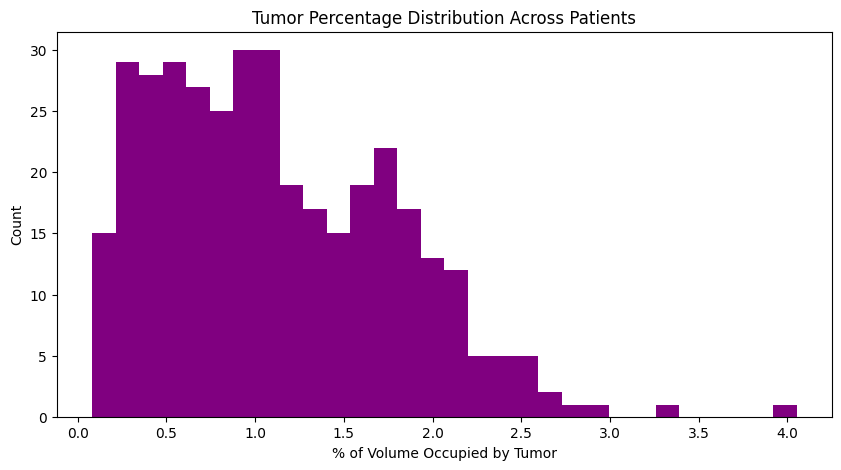

In [7]:
# Cell 2.5 — Dataset-Level MRI Statistics (Before Preprocessing)

import numpy as np
import pandas as pd

print("Computing dataset statistics...")

tumor_stats = []
intensity_stats = []

for case in case_dirs:
    
    flair_files = list(case.glob("*_flair.nii"))
    seg_files   = list(case.glob("*_seg.nii"))
    
    if len(flair_files) == 0 or len(seg_files) == 0:
        continue
    
    flair = nib.load(str(flair_files[0])).get_fdata()
    mask  = nib.load(str(seg_files[0])).get_fdata()
    
    # Basic stats
    mean_intensity = np.mean(flair)
    std_intensity  = np.std(flair)
    min_intensity  = np.min(flair)
    max_intensity  = np.max(flair)
    
    # Tumor percentage
    total_voxels  = np.prod(mask.shape)
    tumor_voxels  = np.sum(mask > 0)
    tumor_percent = (tumor_voxels / total_voxels) * 100
    
    intensity_stats.append([case.name, mean_intensity, std_intensity, min_intensity, max_intensity])
    tumor_stats.append([case.name, tumor_voxels, tumor_percent])

# Convert to DataFrames
df_intensity = pd.DataFrame(intensity_stats, columns=["Case", "Mean_Intensity", "Std_Intensity", "Min", "Max"])
df_tumor = pd.DataFrame(tumor_stats, columns=["Case", "Tumor Voxels", "Tumor Percentage"])

print("\n--- Intensity Statistics (Before Normalization) ---")
display(df_intensity.head())

print("\n--- Tumor Statistics (Voxels & Percentage) ---")
display(df_tumor.head())

print("\nAverage Tumor Percentage Across Dataset:", df_tumor["Tumor Percentage"].mean(), "%")

# Histogram of tumor sizes
plt.figure(figsize=(10,5))
plt.hist(df_tumor["Tumor Percentage"], bins=30, color="purple")
plt.title("Tumor Percentage Distribution Across Patients")
plt.xlabel("% of Volume Occupied by Tumor")
plt.ylabel("Count")
plt.show()


In [8]:
# Cell 3: Convert 3D MRI → 2D slices + preprocess + create dataset splits (SAFE VERSION)

import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def resize_slice(img, size=IMG_SIZE):
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

def normalize(img):
    img = img.astype(np.float32)
    img = img - img.min()
    img = img / (img.max() + 1e-8)
    return img

X_slices = []
Y_slices = []

print("Extracting slices...")

for case in case_dirs:
    flair_files = list(case.glob("*_flair.nii"))
    seg_files   = list(case.glob("*_seg.nii"))

    # Skip cases where FLAIR or SEG is missing
    if len(flair_files) == 0 or len(seg_files) == 0:
        print(f"Skipping {case.name} (Missing flair/seg)")
        continue

    flair_path = flair_files[0]
    mask_path  = seg_files[0]

    flair = nib.load(str(flair_path)).get_fdata()
    mask  = nib.load(str(mask_path)).get_fdata()

    depth = flair.shape[2]

    for i in range(depth):
        img_slice  = flair[:, :, i]
        mask_slice = mask[:, :, i]

        # Skip slices with no tumor
        if mask_slice.max() == 0:
            continue

        # Resize
        img_slice_resized  = resize_slice(img_slice)
        mask_slice_resized = resize_slice(mask_slice, IMG_SIZE)

        # Normalize image
        img_slice_norm = normalize(img_slice_resized)

        # Expand dims for CNN
        img_slice_norm = np.expand_dims(img_slice_norm, -1)
        mask_slice_resized = np.expand_dims(mask_slice_resized, -1)

        X_slices.append(img_slice_norm)
        Y_slices.append(mask_slice_resized)

print("Total usable slices extracted:", len(X_slices))

X_slices = np.array(X_slices, dtype=np.float32)
Y_slices = np.array(Y_slices, dtype=np.float32)

print("X shape:", X_slices.shape)
print("Y shape:", Y_slices.shape)

# Train / Val / Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_slices, Y_slices, test_size=(VAL_SPLIT + TEST_SPLIT), random_state=SEED
)

relative_val_split = VAL_SPLIT / (VAL_SPLIT + TEST_SPLIT)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(1 - relative_val_split), random_state=SEED
)

print("\nFinal dataset sizes:")
print("Train:", X_train.shape[0])
print("Val  :", X_val.shape[0])
print("Test :", X_test.shape[0])

Extracting slices...
Skipping BraTS20_Training_355 (Missing flair/seg)
Total usable slices extracted: 24354
X shape: (24354, 128, 128, 1)
Y shape: (24354, 128, 128, 1)

Final dataset sizes:
Train: 18265
Val  : 3653
Test : 2436



Computing statistics on extracted 2D slices...


,Tumor Pixels,Mean Intensity,Std Intensity
0,2,0.064881,0.196581
1,33,0.072576,0.211850
2,77,0.074857,0.212527
3,94,0.063475,0.175113
4,110,0.071071,0.190442



--- Slice-Level Summary Statistics ---
       Tumor Pixels  Mean Intensity  Std Intensity
count  24354.000000    24354.000000   24354.000000
mean     467.646136        0.112339       0.207281
std      361.716428        0.039052       0.051088
min        1.000000        0.001021       0.024160
25%      165.000000        0.084139       0.169637
50%      402.000000        0.111161       0.205953
75%      695.000000        0.139622       0.247044
max     1934.000000        0.232219       0.349774


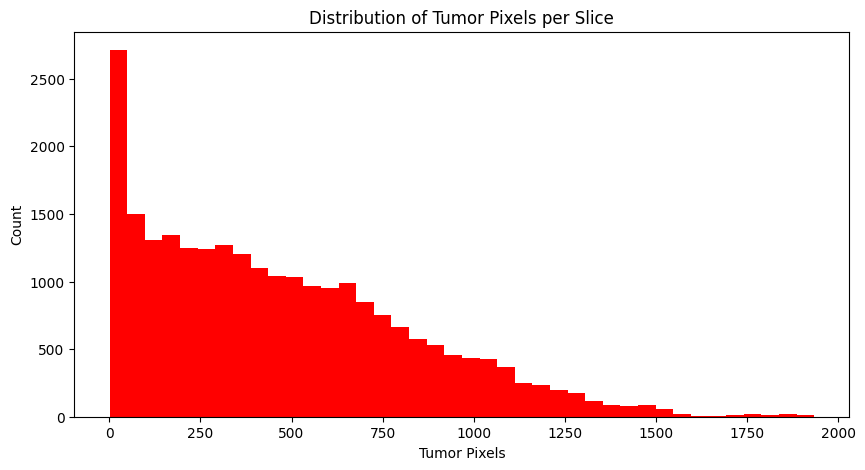

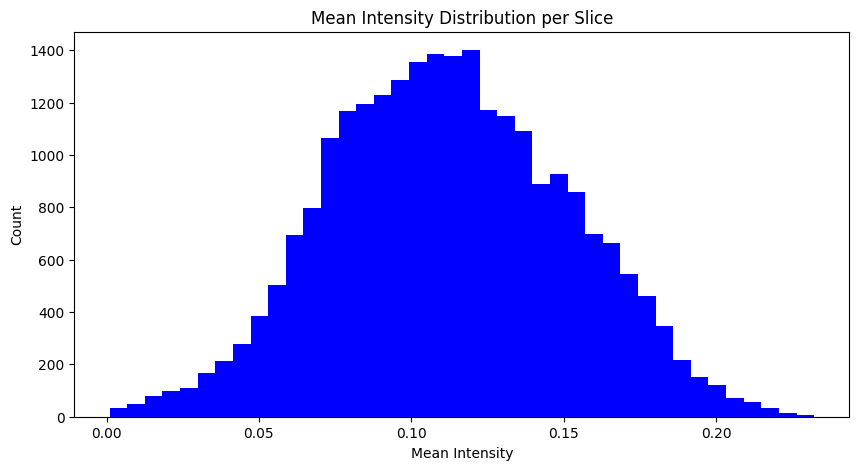

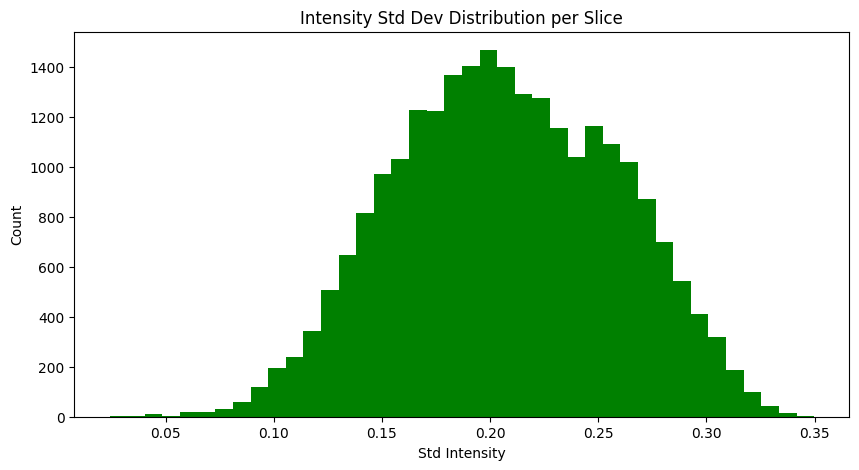

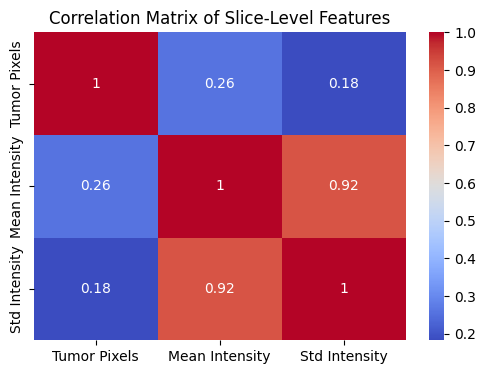

In [9]:
# Cell 3.5 — Slice-Level Statistics After Preprocessing

import numpy as np
import pandas as pd

print("\nComputing statistics on extracted 2D slices...")

slice_areas = []
slice_means = []
slice_stds  = []

for img, mask in zip(X_slices, Y_slices):

    # Flatten mask and count tumor pixels
    tumor_pixels = np.sum(mask > 0)
    slice_areas.append(tumor_pixels)

    # Image intensity stats
    slice_means.append(np.mean(img))
    slice_stds.append(np.std(img))

# Create DataFrame
df_slices = pd.DataFrame({
    "Tumor Pixels": slice_areas,
    "Mean Intensity": slice_means,
    "Std Intensity": slice_stds
})

display(df_slices.head())

print("\n--- Slice-Level Summary Statistics ---")
print(df_slices.describe())

# Tumor pixel distribution
plt.figure(figsize=(10,5))
plt.hist(df_slices["Tumor Pixels"], bins=40, color="red")
plt.title("Distribution of Tumor Pixels per Slice")
plt.xlabel("Tumor Pixels")
plt.ylabel("Count")
plt.show()

# Intensity distribution
plt.figure(figsize=(10,5))
plt.hist(df_slices["Mean Intensity"], bins=40, color="blue")
plt.title("Mean Intensity Distribution per Slice")
plt.xlabel("Mean Intensity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df_slices["Std Intensity"], bins=40, color="green")
plt.title("Intensity Std Dev Distribution per Slice")
plt.xlabel("Std Intensity")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(df_slices.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Slice-Level Features")
plt.show()


In [10]:
# Cell 4: Prepare masks for binary segmentation + build U-Net model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# 1. Binarize the masks
# -----------------------------
# BraTS masks usually have labels {0, 1, 2, 4}
# For now, we do binary segmentation: tumor (any >0) vs background (0)

y_train_bin = (y_train > 0).astype("float32")
y_val_bin   = (y_val > 0).astype("float32")
y_test_bin  = (y_test > 0).astype("float32")

print("y_train_bin unique values:", np.unique(y_train_bin))
print("y_val_bin unique values:",   np.unique(y_val_bin))
print("y_test_bin unique values:",  np.unique(y_test_bin))

# -----------------------------
# 2. Define Dice metric & loss
# -----------------------------

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# -----------------------------
# 3. Build U-Net
# -----------------------------

def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = keras.Model(inputs, outputs, name="u_net_2d")
    return model

# -----------------------------
# 4. Create and compile model
# -----------------------------

input_shape = X_train.shape[1:]   # should be (128, 128, 1)
print("Input shape for U-Net:", input_shape)

model = build_unet(input_shape)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",      # or dice_loss, or combo
    metrics=["accuracy", dice_coef],
)

model.summary()

y_train_bin unique values: [0. 1.]
y_val_bin unique values: [0. 1.]
y_test_bin unique values: [0. 1.]
Input shape for U-Net: (128, 128, 1)


Model: "u_net_2d"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

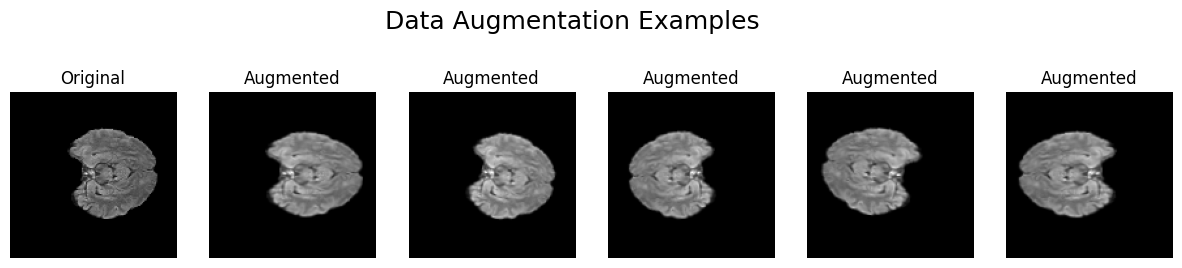

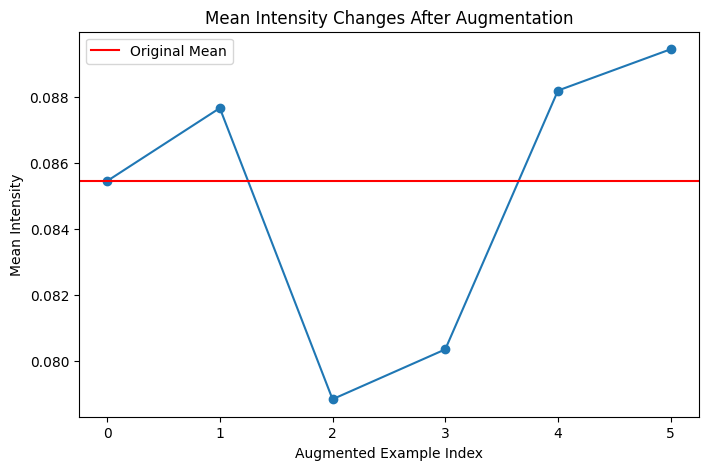

Original mean intensity: 0.08545553
Augmented mean intensities: [0.08545553, 0.08766911, 0.078838125, 0.08035013, 0.08820088, 0.08945386]
Augmentation mean shift (std): 0.0040208623


In [11]:
# Cell 4.5 — Data Augmentation Statistics (Before Training)

import tensorflow as tf
import matplotlib.pyplot as plt

# Define augmentation pipeline
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.1, 0.1),
], name="augmentation_layer")

# Pick 1 example slice
sample_img = X_train[0]
sample_mask = y_train_bin[0]

augmented_imgs = [sample_img]
augmented_masks = [sample_mask]

# Generate 5 augmented versions
for _ in range(5):
    aug_img, aug_mask = augment(sample_img, training=True), augment(sample_mask, training=True)
    augmented_imgs.append(aug_img.numpy())
    augmented_masks.append(aug_mask.numpy())

# Visualize augmentation examples
plt.figure(figsize=(15, 6))
for i, img in enumerate(augmented_imgs[:6]):
    plt.subplot(2, 6, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title("Augmented" if i > 0 else "Original")
    plt.axis("off")

plt.suptitle("Data Augmentation Examples", fontsize=18)
plt.show()

# Statistical analysis of augmentation
original_mean = np.mean(sample_img)
aug_means = [np.mean(img) for img in augmented_imgs]

plt.figure(figsize=(8,5))
plt.plot(aug_means, marker="o")
plt.axhline(original_mean, color="red", label="Original Mean")
plt.title("Mean Intensity Changes After Augmentation")
plt.xlabel("Augmented Example Index")
plt.ylabel("Mean Intensity")
plt.legend()
plt.show()

print("Original mean intensity:", original_mean)
print("Augmented mean intensities:", aug_means)
print("Augmentation mean shift (std):", np.std(aug_means))


In [16]:
# Cell 0 — MUST be the first cell in the entire notebook

import os

# Disable XLA entirely
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_enable_triton_gemm=false"

# Disable oneDNN optimizations
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Disable autotuning for cudnn (where the bugs happen)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print("✔ Environment variables set. NOW restart the kernel.")


✔ Environment variables set. NOW restart the kernel.


In [17]:
# Cell 5 (UPDATED WITH VAL ACC DISPLAY)

import tensorflow as tf
from tensorflow import keras

# -----------------------------
# Custom callback to print validation accuracy
# -----------------------------
class PrintValAccCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        print(f"➡️  End of Epoch {epoch+1}: Validation Accuracy = {val_acc:.4f}")

# -----------------------------
# 1. Create tf.data datasets
# -----------------------------

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_bin))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_bin))

train_ds = train_ds.shuffle(5000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))

# -----------------------------
# 2. Callbacks (UPDATED .keras filenames)
# -----------------------------

checkpoint = keras.callbacks.ModelCheckpoint(
    "unet_brain_tumor.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

val_acc_printer = PrintValAccCallback()

callbacks = [checkpoint, early_stop, reduce_lr, val_acc_printer]

# -----------------------------
# 3. Train the model
# -----------------------------

EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final model
model.save("unet_brain_tumor_final.keras")

print("Training complete.")


Train batches: 571
Val batches: 115
Epoch 1/15
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9957 - dice_coef: 0.6132 - loss: 0.0362
Epoch 1: val_loss improved from inf to 0.02805, saving model to unet_brain_tumor.keras
➡️  End of Epoch 1: Validation Accuracy = 0.9954
571/571 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.9957 - dice_coef: 0.6132 - loss: 0.0362 - val_accuracy: 0.9954 - val_dice_coef: 0.6827 - val_loss: 0.0280 - learning_rate: 1.0000e-04
Epoch 2/15
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9962 - dice_coef: 0.7080 - loss: 0.0248
Epoch 2: val_loss improved from 0.02805 to 0.02068, saving model to unet_brain_tumor.keras
➡️  End of Epoch 2: Validation Accuracy = 0.9962
571/571 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9962 - dice_coef: 0.7081 - loss: 0.0248 - val_accuracy: 0.9962 - val_dice_coef: 0.7531 - val_loss: 0.0207 - learning_rate: 1.0000e-04
Epoch 3/15
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9967 - dice_coef: 0.7783 

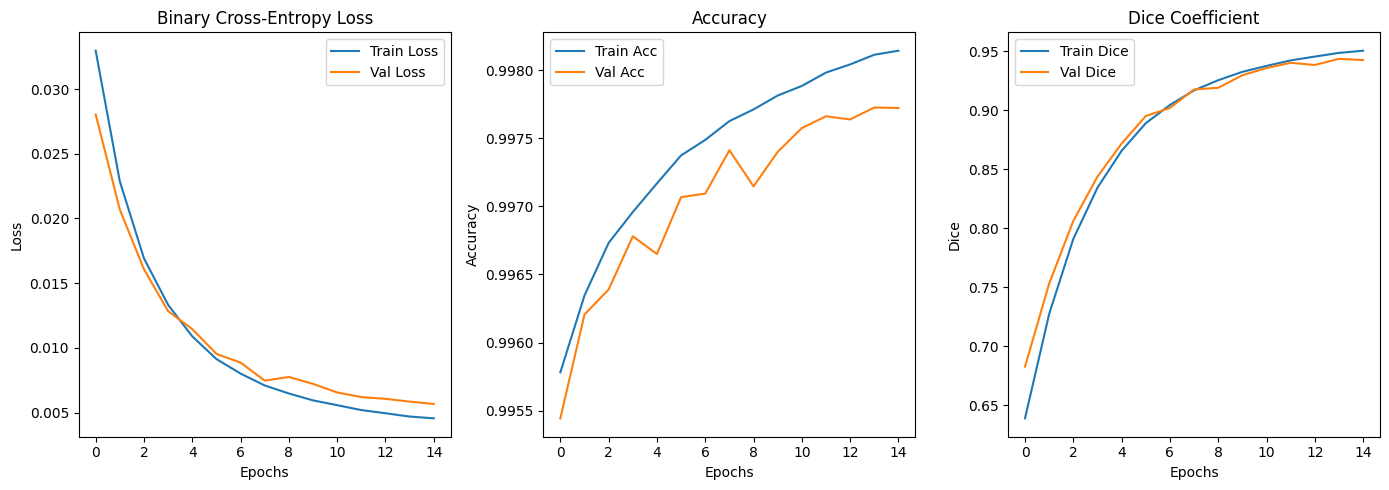

In [ ]:
# Cell 5.5 — Training Statistics Visualization (Loss, Accuracy, Dice)

import matplotlib.pyplot as plt

# Training curves
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,3,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Binary Cross-Entropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Dice Coefficient
plt.subplot(1,3,3)
plt.plot(history.history["dice_coef"], label="Train Dice")
plt.plot(history.history["val_dice_coef"], label="Val Dice")
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice")
plt.legend()

plt.tight_layout()
plt.show()


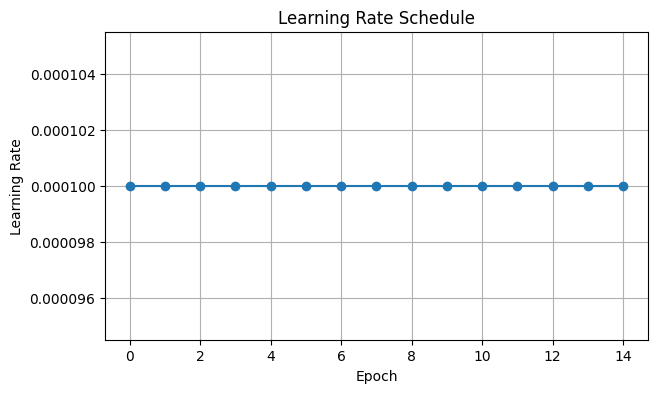

In [20]:
# Cell 5.8 — Visualize Learning Rate Over Epochs (TF 2.15+ FIXED)

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

lrs = []

for epoch in range(len(history.history["loss"])):
    # Correct attribute for TF 2.15+
    lr = float(keras.backend.get_value(model.optimizer.learning_rate))
    lrs.append(lr)

plt.figure(figsize=(7,4))
plt.plot(lrs, marker="o")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


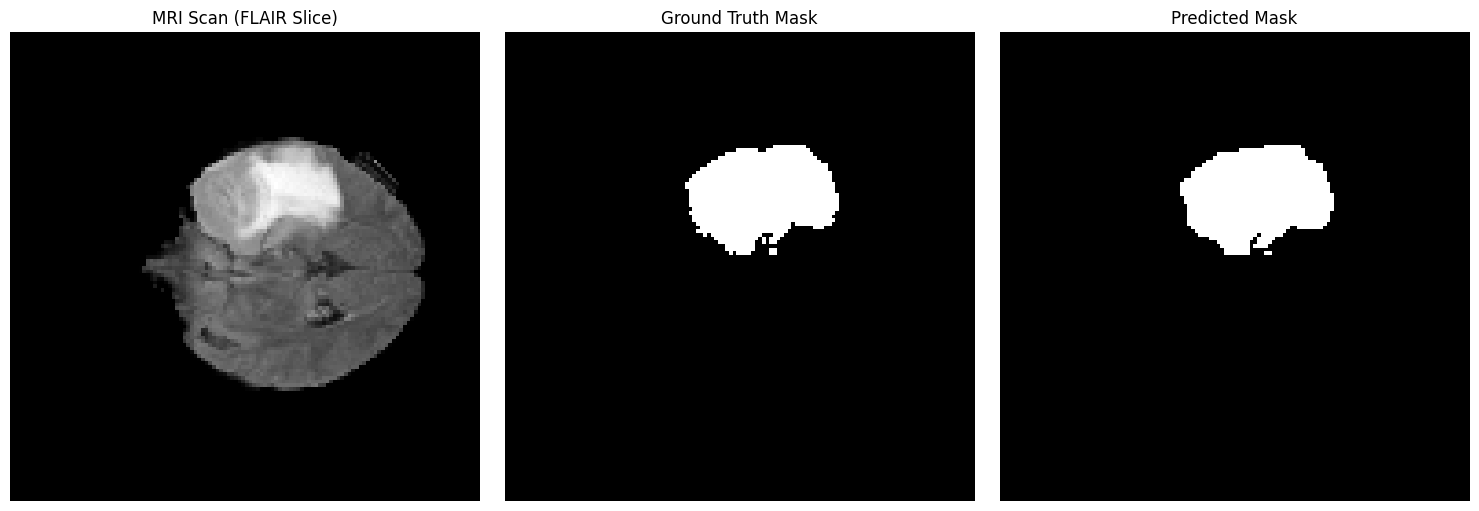

In [27]:
# Cell 6 — Visualize Random MRI, Ground Truth, and Prediction (Loop Version)

import random
import matplotlib.pyplot as plt

def show_random_prediction():
    # Pick random test index
    idx = random.randint(0, len(X_test) - 1)

    test_img  = X_test[idx]
    test_mask = y_test_bin[idx]

    # Model prediction
    pred = model.predict(test_img[np.newaxis, ...])[0]
    pred_mask = (pred > 0.5).astype("float32")

    # Plot
    plt.figure(figsize=(15, 5))

    # Original MRI
    plt.subplot(1, 3, 1)
    plt.title("MRI Scan (FLAIR Slice)")
    plt.imshow(test_img.squeeze(), cmap="gray")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(test_mask.squeeze(), cmap="gray")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# -----------------------
# Run N times
# -----------------------
N = 1    # Change this to 5, 10, etc. to show multiple predictions
for _ in range(N):
    show_random_prediction()


In [28]:
# Cell: Download trained model from Kaggle notebook

from pathlib import Path
from IPython.display import FileLink

model_path = Path("unet_brain_tumor_final.keras")

if model_path.exists():
    print("Model found. Click below to download:")
    display(FileLink(str(model_path)))
else:
    print("❌ Model file not found. Check filename or run training first.")


Model found. Click below to download:


/kaggle/working/unet_brain_tumor_final.keras